## Artificial Neural Network

### Libraries

In [6]:
# standart data tools
import numpy as np
import pandas as pd

# common visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns

# CNN layers and the Deep Learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch


# splitting tool for the validation set
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

2024-04-13 16:28:15.493033: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 16:28:15.496084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 16:28:15.531299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 16:28:16.239187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Loading

In [7]:
X = np.load('archive/X_2024-04-12_01-37-39.npy')
y = np.load('archive/Y_2024-04-12_01-37-39.npy')

### Splitting Train (70%), Validation (15%) and Test Datasets (15%)

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

x_train = x_train.reshape(-1, 64, 64, 1)
x_val = x_val.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

### Splitting Train (70%), Validation (15%) and Test Datasets (15%) for augmentated dataset

In [9]:
X_augmented = np.load('archive/Augmentation/X_augmented.npy')
Y_augmented = np.load('archive/Augmentation/Y_augmented.npy')

X_train_augmented, X_temp_augmented, Y_train_augmented, Y_temp_augmented = train_test_split(X_augmented, Y_augmented, test_size=0.3, random_state=42)
X_val_augmented, X_test_augmented, Y_val_augmented, Y_test_augmented = train_test_split(X_temp_augmented, Y_temp_augmented, test_size=0.5, random_state=42)

X_train_augmented = X_train_augmented.reshape(-1, 64, 64, 1)
X_val_augmented = X_val_augmented.reshape(-1, 64, 64, 1)
X_test_augmented = X_test_augmented.reshape(-1, 64, 64, 1)

### Confusion Matrix Function

In [11]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Creating the ANN Model

In [22]:
ANN_model = Sequential([
  Flatten(),
  Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.3),
  Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.2),
  Dense(10, activation="softmax")
])

### Summary of the Model

In [23]:
ANN_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilation

In [24]:
ANN_model.compile(optimizer=Adam(learning_rate=0.00002), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Training

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

results = ANN_model.fit(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/600


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0997 - loss: 3.7681 - val_accuracy: 0.1230 - val_loss: 3.4962
Epoch 2/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1215 - loss: 3.5496 - val_accuracy: 0.1489 - val_loss: 3.4257
Epoch 3/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1404 - loss: 3.4986 - val_accuracy: 0.2460 - val_loss: 3.3834
Epoch 4/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1725 - loss: 3.4136 - val_accuracy: 0.2201 - val_loss: 3.3431
Epoch 5/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2120 - loss: 3.3480 - val_accuracy: 0.3495 - val_loss: 3.2715
Epoch 6/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1906 - loss: 3.3443 - val_accuracy: 0.2524 - val_loss: 3.2509
Epoch 7/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2246 - loss: 3.2817 - val_accuracy: 0.3560 - val_loss: 3.1897
Epoch 8/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2827 - loss: 3.2074 - val_accuracy: 0.4304 - val_l

### Plotting Training and Validating Accuracy/Loss

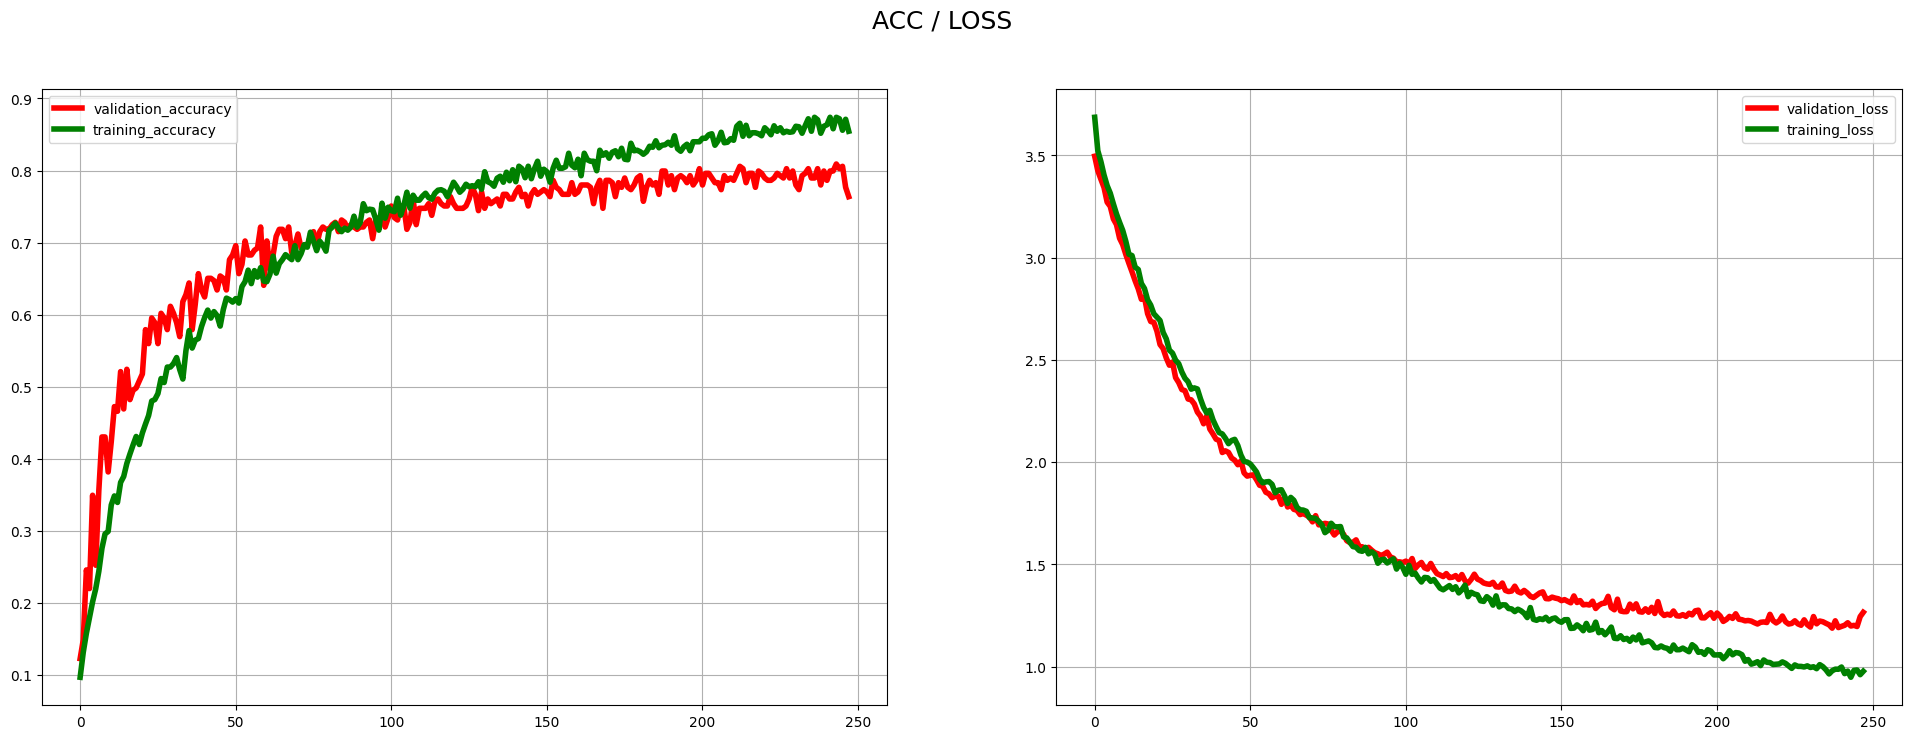

In [26]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

### Test Set Analysis

 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Results for Train set
Accuracy:  0.9057519057519058
F1 Score:  0.9054459164467189
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       150
           1       0.90      0.95      0.92       136
           2       0.93      0.90      0.91       130
           3       0.97      0.94      0.95       143
           4       0.90      0.82      0.86       155
           5       0.95      0.97      0.96       152
           6       0.90      0.87      0.88       142
           7       0.83      0.86      0.85       144
           8       0.89      0.86      0.88       146
           9       0.89      0.97      0.92       145

    accuracy                           0.91      1443
   macro avg       0.91      0.91      0.91      1443
weighted avg       0.91      0.91      0.91      1443



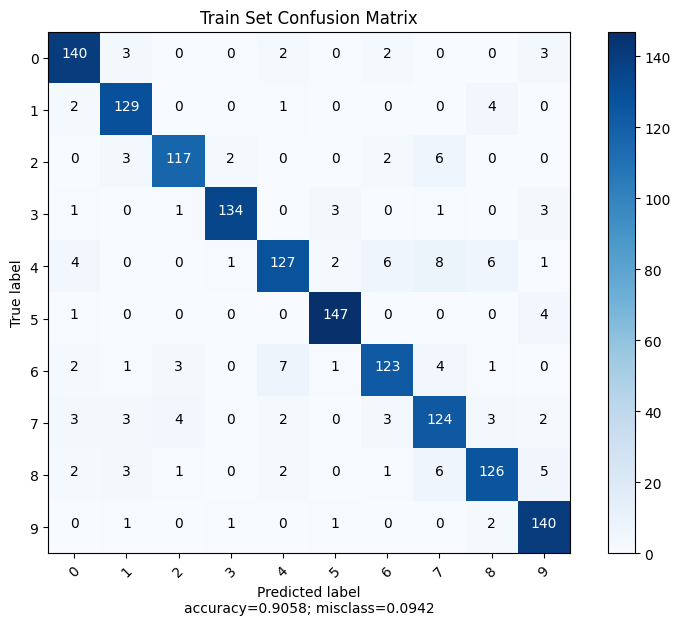

Results for Validation set
Accuracy:  0.8025889967637541
F1 Score:  0.8027448968325887
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.92      0.92      0.92        38
           2       0.76      0.74      0.75        35
           3       0.88      0.97      0.92        30
           4       0.81      0.78      0.79        32
           5       0.80      0.83      0.82        24
           6       0.83      0.71      0.76        34
           7       0.61      0.69      0.65        32
           8       0.72      0.75      0.74        28
           9       0.85      0.79      0.82        29

    accuracy                           0.80       309
   macro avg       0.80      0.80      0.80       309
weighted avg       0.81      0.80      0.80       309



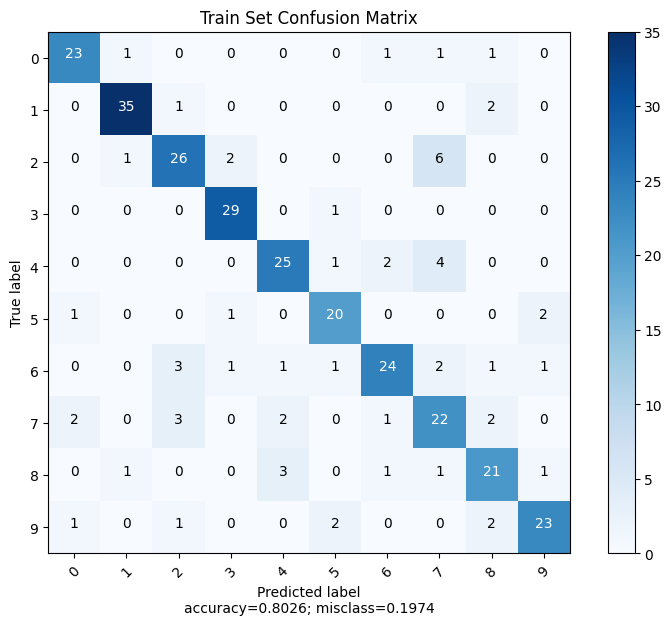

Results for Test set
Accuracy:  0.8064516129032258
F1 Score:  0.8037099803939698
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.84      0.84      0.84        32
           2       0.84      0.63      0.72        41
           3       0.85      0.88      0.87        33
           4       0.56      0.50      0.53        20
           5       0.86      0.97      0.91        31
           6       0.88      0.74      0.81        31
           7       0.77      0.90      0.83        30
           8       0.89      0.71      0.79        34
           9       0.64      0.90      0.75        30

    accuracy                           0.81       310
   macro avg       0.80      0.80      0.80       310
weighted avg       0.81      0.81      0.80       310



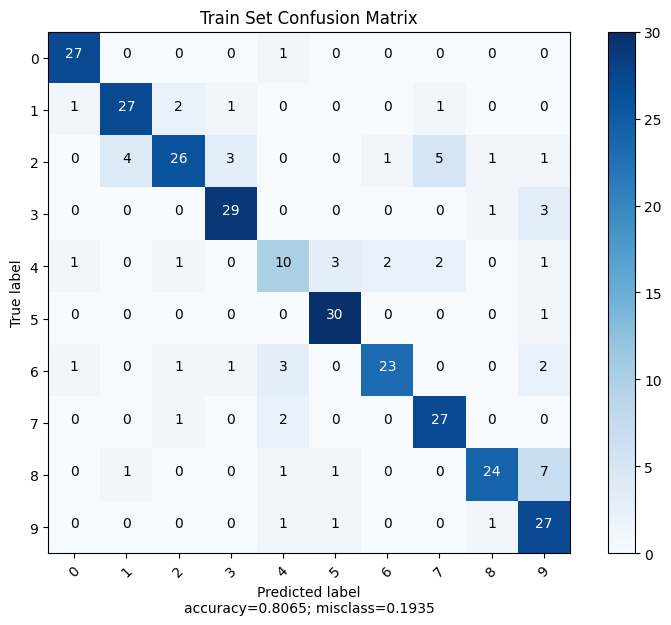

In [36]:
y_pred_train = ANN_model.predict(x_train)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_train_classes = np.argmax(y_train, axis=1)

y_pred = ANN_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

y_pred_val = ANN_model.predict(x_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

datasets = {
    "Train": (y_train_classes, y_pred_classes_train),
    "Validation": (y_val_classes, y_pred_classes_val),
    "Test": (y_test_classes, y_pred_classes)
}

for dataset, (y_true, y_pred) in datasets.items():
    print(f"Results for {dataset} set")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_true).astype(str), title=f'{set_name} Set Confusion Matrix', normalize=False)


### Predictions

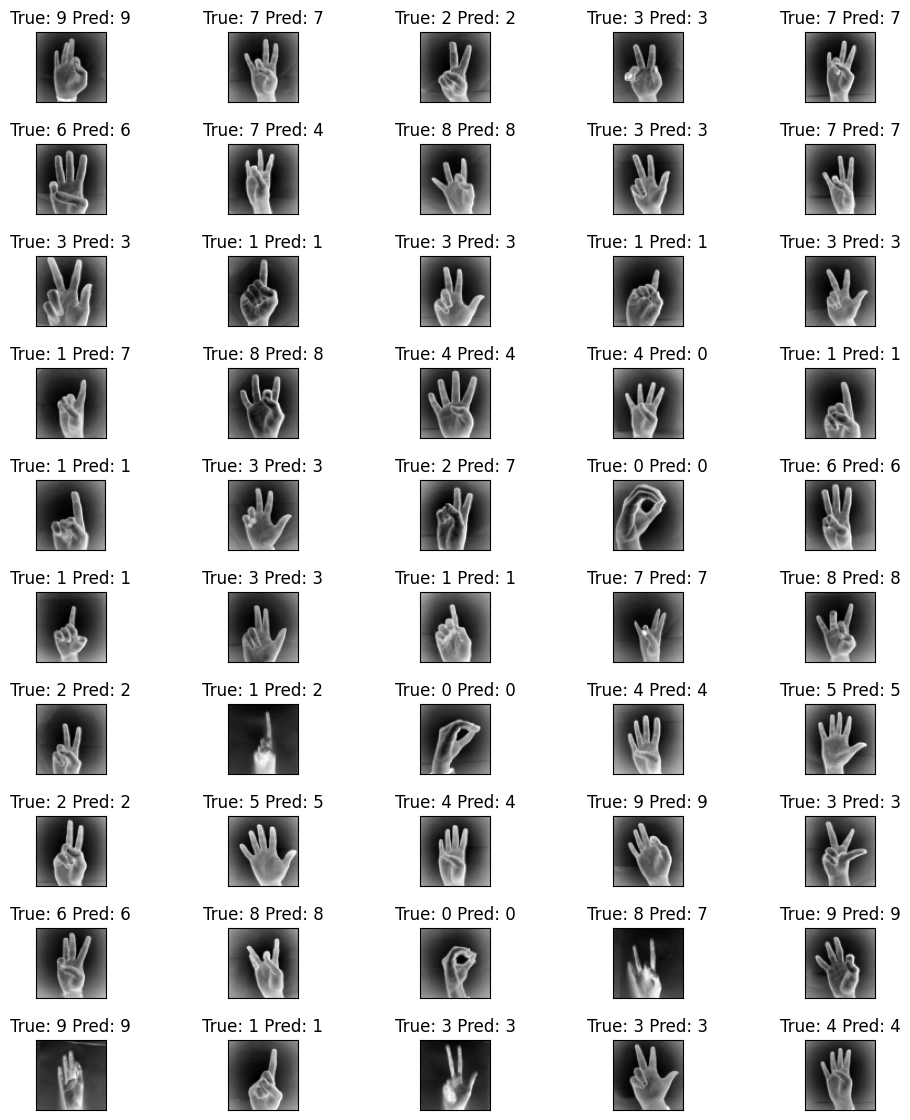

In [14]:
x_val_test =  x_test.reshape(x_test.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test[i].argmax()} Pred: {y_pred[i].argmax()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.6)
plt.show()

## Hyperparameter Tuning

#### Model Construction with original dataset

In [12]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(x_train.shape[1:]))) #alternar com X_train_augmented
    model.add(Dense(units=hp.Int('units_layer_1', min_value=256, max_value=1024, step=256),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_1', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_layer_2', min_value=128, max_value=512, step=128),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

#### Model Construction with augmentated dataset

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(X_train_augmented.shape[1:])))
    model.add(Dense(units=hp.Int('units_layer_1', min_value=256, max_value=1024, step=256),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_1', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_layer_2', min_value=128, max_value=512, step=128),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

#### Training with original dataset

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Número máximo de combinações de hiperparâmetros para testar
    executions_per_trial=1,  # Número de modelos que devem ser construídos e ajustados para cada tentativa
    directory='ANN_tuning',  # Diretório onde os logs de sumário devem ser salvos
    project_name='keras_tuner_ANN'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
    Melhores hiperparâmetros encontrados:
      - Número de neurônios na camada 1: {best_hps.get('units_layer_1')}
      - Taxa de regularização L2 na camada 1: {best_hps.get('l2_layer_1')}
      - Taxa de dropout na camada 1: {best_hps.get('dropout_layer_1')}
      - Número de neurônios na camada 2: {best_hps.get('units_layer_2')}
      - Taxa de regularização L2 na camada 2: {best_hps.get('l2_layer_2')}
      - Taxa de dropout na camada 2: {best_hps.get('dropout_layer_2')}
      - Taxa de aprendizado: {best_hps.get('learning_rate')}
      """)

tuned_ANN_model = tuner.hypermodel.build(best_hps)

tuned_results = tuned_ANN_model.fit(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

Reloading Tuner from ANN_tuning/keras_tuner_ANN/tuner0.json

    Melhores hiperparâmetros encontrados:
      - Número de neurônios na camada 1: 1024
      - Taxa de regularização L2 na camada 1: 0.001678637274473244
      - Taxa de dropout na camada 1: 0.30000000000000004
      - Número de neurônios na camada 2: 384
      - Taxa de regularização L2 na camada 2: 0.0006236776945025639
      - Taxa de dropout na camada 2: 0.2
      - Taxa de aprendizado: 7.811100466901e-05
      
Epoch 1/600


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1237 - loss: 5.4866 - val_accuracy: 0.3301 - val_loss: 4.9902
Epoch 2/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1395 - loss: 5.0365 - val_accuracy: 0.1650 - val_loss: 4.7432
Epoch 3/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1700 - loss: 4.7175 - val_accuracy: 0.2104 - val_loss: 4.5132
Epoch 4/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1880 - loss: 4.5106 - val_accuracy: 0.2880 - val_loss: 4.2805
Epoch 5/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2732 - loss: 4.2169 - val_accuracy: 0.3463 - val_loss: 4.0369
Epoch 6/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2669 - loss: 4.0435 - val_accuracy: 0.3463 - val_loss: 3.8815
Epoch 7/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2991 - loss: 3.8974 - val_accuracy: 0.4854 - val_loss: 3.7142
Epoch 8/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3225 - loss: 3.7544 - val_accuracy: 0.4595 - val_l

#### Training with augmentated dataset

In [14]:
tuned_ANN_model = tuner.hypermodel.build(best_hps)

tuned_results_augmented = tuned_ANN_model.fit(X_train_augmented, Y_train_augmented, epochs=600, validation_data=(X_val_augmented, Y_val_augmented))

/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/600


2024-04-13 04:22:18.805210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307429376 exceeds 10% of free system memory.


587/587 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.1646 - loss: 4.7960 - val_accuracy: 0.4683 - val_loss: 3.3462
Epoch 2/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.4139 - loss: 3.2086 - val_accuracy: 0.6006 - val_loss: 2.5009
Epoch 3/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5301 - loss: 2.4892 - val_accuracy: 0.6797 - val_loss: 1.9991
Epoch 4/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6044 - loss: 2.0368 - val_accuracy: 0.6100 - val_loss: 1.8404
Epoch 5/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6258 - loss: 1.7712 - val_accuracy: 0.6854 - val_loss: 1.5571
Epoch 6/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.6613 - loss: 1.5535 - val_accuracy: 0.7060 - val_loss: 1.3675
Epoch 7/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6814 - loss: 1.4134 - val_accuracy: 0.7267 - val_loss: 1.3077
Epoch 8/600
587/587 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6769 - loss: 1.3560 - val_

### Plotting Training and Validating Accuracy/Loss

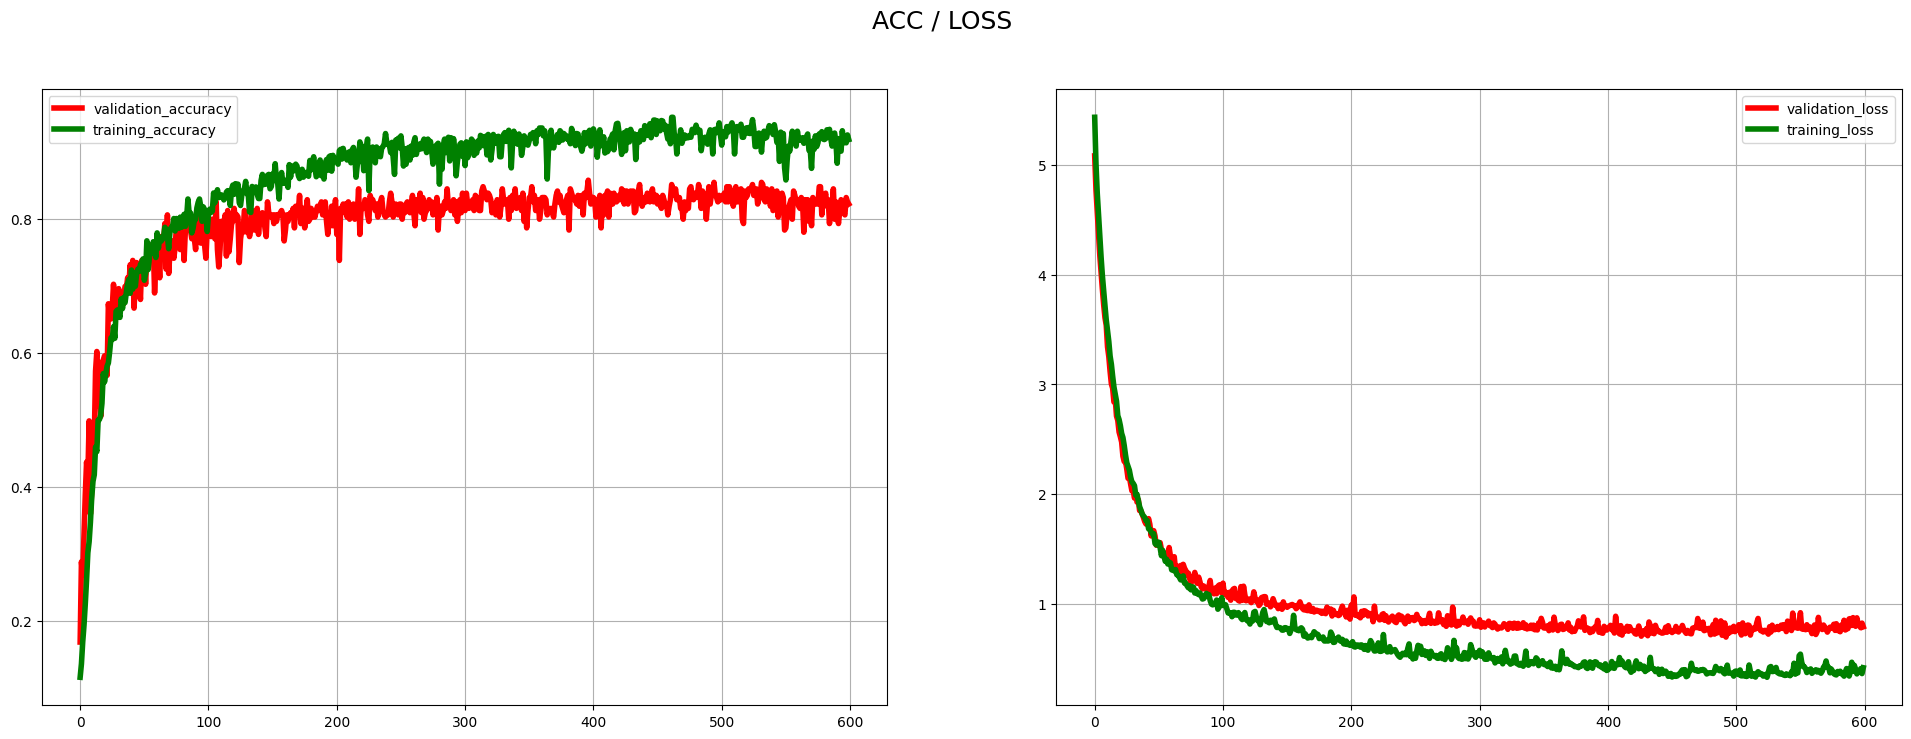

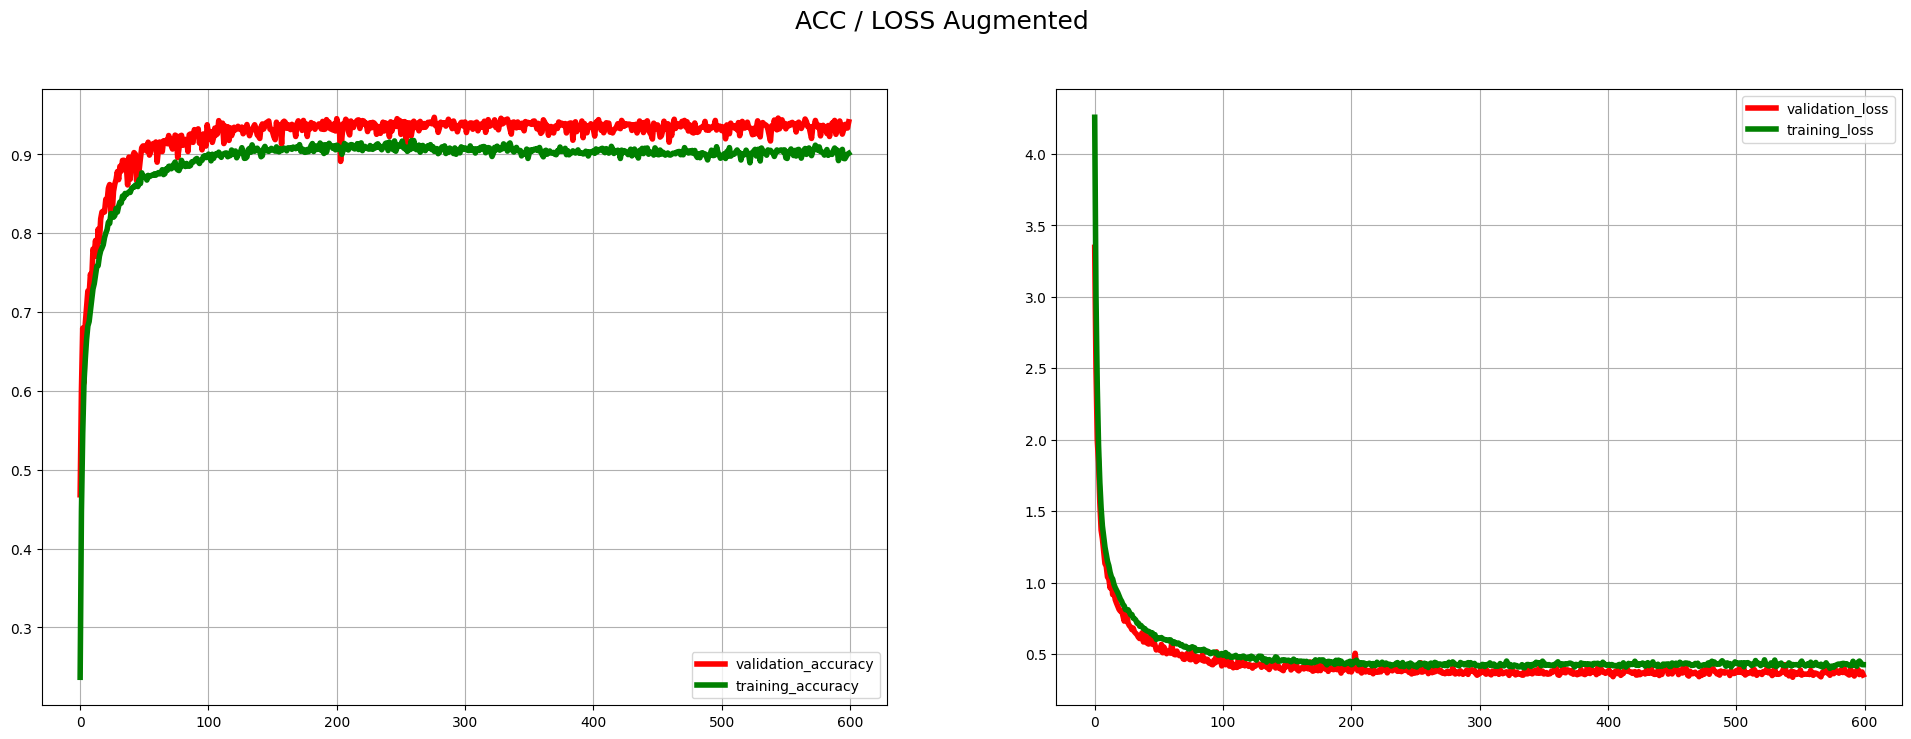

In [16]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(tuned_results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(tuned_results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(tuned_results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(tuned_results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
plt.plot(tuned_results_augmented.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(tuned_results_augmented.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(tuned_results_augmented.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(tuned_results_augmented.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS Augmented",fontsize=18)

plt.show()


### Test Set Analysis (Original Dataset)

Only run if previously trained with original dataset (Do not run if trained with augmentated dataset)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Results for Train set
Accuracy:  0.9847539847539848
F1 Score:  0.9848014512384922
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       1.00      0.99      1.00       136
           2       1.00      0.98      0.99       130
           3       1.00      0.99      0.99       143
           4       0.97      0.98      0.97       155
           5       1.00      0.99      1.00       152
           6       0.97      0.94      0.96       142
           7       0.94      1.00      0.97       144
           8       1.00      0.97      0.99       146
           9       0.99      1.00      0.99       145

    accuracy                           0.98      1443
   macro avg       0.99      0.98      0.98      1443
weighted avg       0.99      0.98      0.98      1443



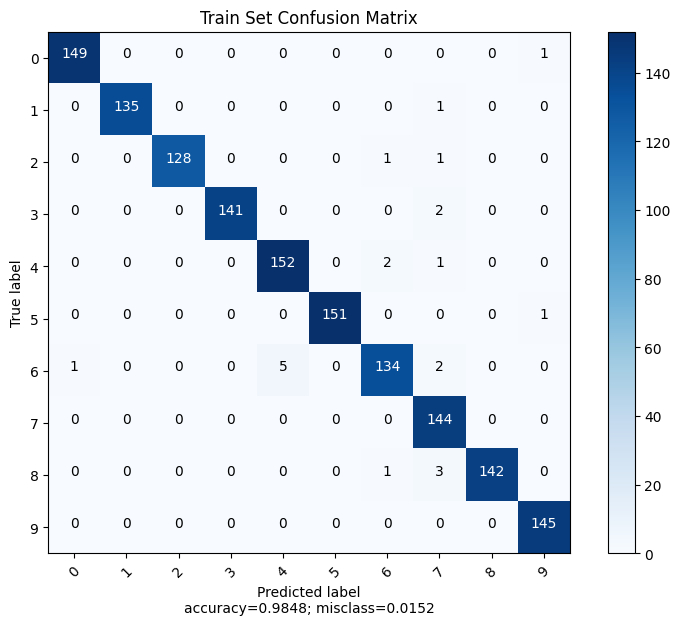

Results for Validation set
Accuracy:  0.8317152103559871
F1 Score:  0.8334661910415614
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.97      0.92      0.95        38
           2       0.87      0.74      0.80        35
           3       0.91      1.00      0.95        30
           4       0.74      0.88      0.80        32
           5       0.95      0.83      0.89        24
           6       0.87      0.76      0.81        34
           7       0.63      0.75      0.69        32
           8       0.72      0.75      0.74        28
           9       0.92      0.83      0.87        29

    accuracy                           0.83       309
   macro avg       0.84      0.83      0.83       309
weighted avg       0.84      0.83      0.83       309



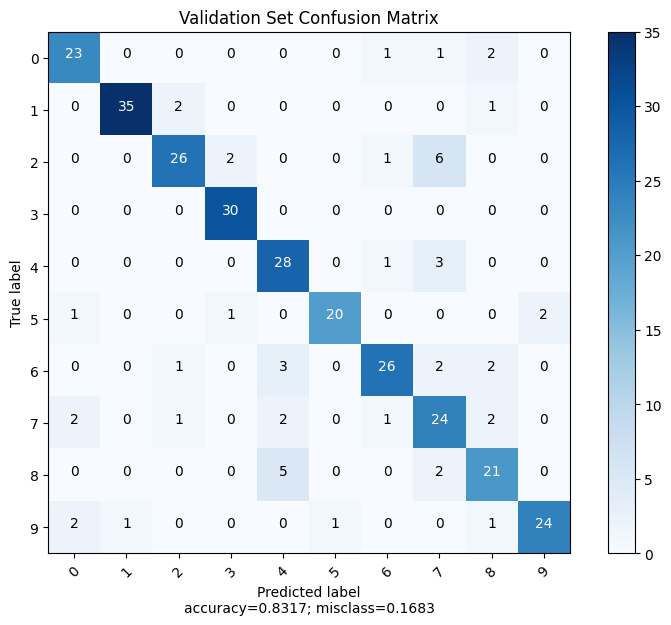

Results for Test set
Accuracy:  0.8096774193548387
F1 Score:  0.8100504375034141
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.90      0.81      0.85        32
           2       0.83      0.61      0.70        41
           3       1.00      0.76      0.86        33
           4       0.62      0.75      0.68        20
           5       0.94      0.94      0.94        31
           6       0.77      0.74      0.75        31
           7       0.65      0.93      0.77        30
           8       0.89      0.74      0.81        34
           9       0.70      0.93      0.80        30

    accuracy                           0.81       310
   macro avg       0.82      0.82      0.81       310
weighted avg       0.83      0.81      0.81       310



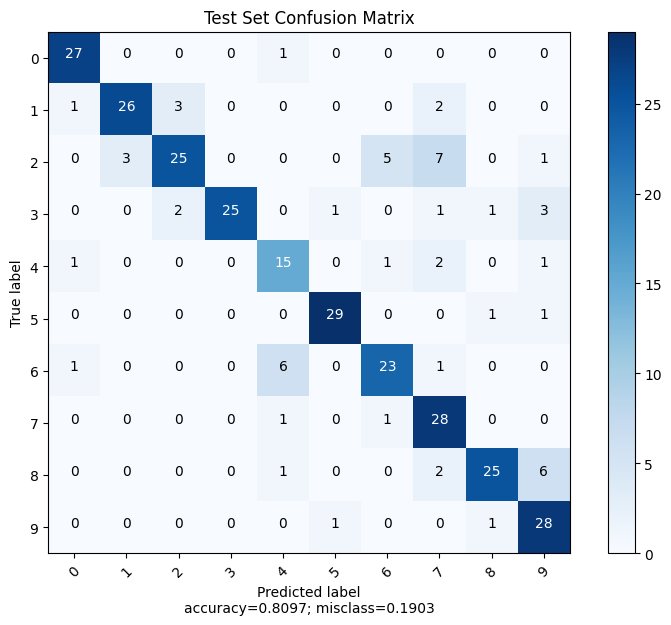

In [17]:
tuned_y_pred_train = tuned_ANN_model.predict(x_train)
tuned_y_pred_classes_train = np.argmax(tuned_y_pred_train, axis=1)
tuned_y_train_classes = np.argmax(y_train, axis=1)

tuned_y_pred = tuned_ANN_model.predict(x_test)
tuned_y_pred_classes = np.argmax(tuned_y_pred, axis=1)
tuned_y_test_classes = np.argmax(y_test, axis=1)

tuned_y_pred_val = tuned_ANN_model.predict(x_val)
tuned_y_pred_classes_val = np.argmax(tuned_y_pred_val, axis=1)
tuned_y_val_classes = np.argmax(y_val, axis=1)

tuned_datasets = {
    "Train": (tuned_y_train_classes, tuned_y_pred_classes_train),
    "Validation": (tuned_y_val_classes, tuned_y_pred_classes_val),
    "Test": (tuned_y_test_classes, tuned_y_pred_classes)
}

for dataset, (y_true, y_pred) in tuned_datasets.items():
    print(f"Results for {dataset} set")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_true).astype(str), title=f'{dataset} Set Confusion Matrix', normalize=False)

### Predictions (Original Dataset)

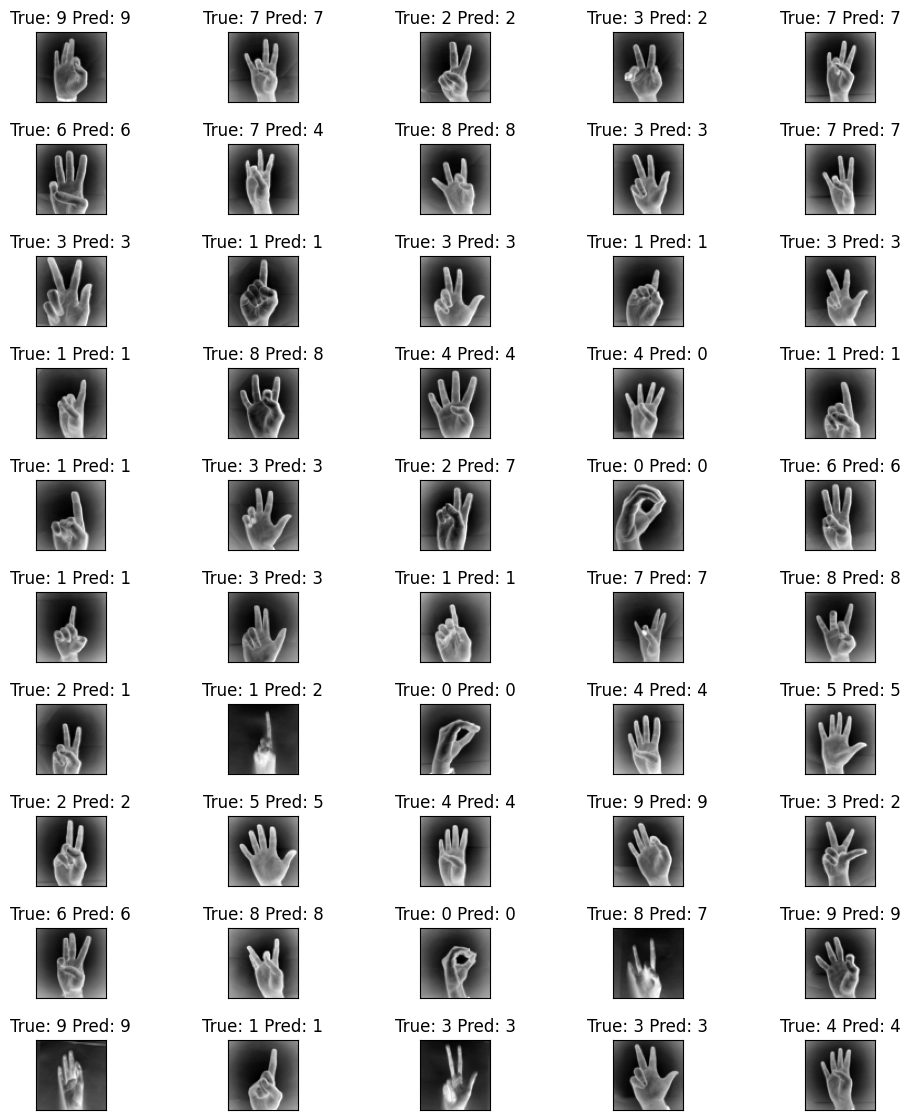

In [18]:
x_val_test =  x_test.reshape(x_test.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test[i].argmax()} Pred: {tuned_y_pred[i].argmax()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.6)
plt.show()

### Test Set Analysis (Augmented Dataset)

Only run if previously trained with augmentated dataset (Do not run if trained with original dataset)

In [2]:
tuned_y_pred_train = tuned_ANN_model.predict(X_train_augmented)
tuned_y_pred_classes_train = np.argmax(tuned_y_pred_train, axis=1)
y_train_classes = np.argmax(Y_train_augmented, axis=1)

tuned_y_pred = tuned_ANN_model.predict(X_test_augmented)
tuned_y_pred_classes = np.argmax(tuned_y_pred, axis=1)
y_test_classes = np.argmax(Y_test_augmented, axis=1)

tuned_y_pred_val = tuned_ANN_model.predict(X_val_augmented)
tuned_y_pred_classes_val = np.argmax(tuned_y_pred_val, axis=1)
y_val_classes = np.argmax(Y_val_augmented, axis=1)
                          

datasets = {
    "Train": (y_train_classes, tuned_y_pred_classes_train),
    "Validation": (y_val_classes, tuned_y_pred_classes_val),
    "Test": (y_test_classes, tuned_y_pred_classes)
}

for dataset, (y_true, y_pred) in datasets.items():
    print(f"Results for {dataset} set")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_true).astype(str), title=f'{set_name} Set Confusion Matrix', normalize=False)

NameError: name 'tuner' is not defined

### Predictions (Augmented Dataset)

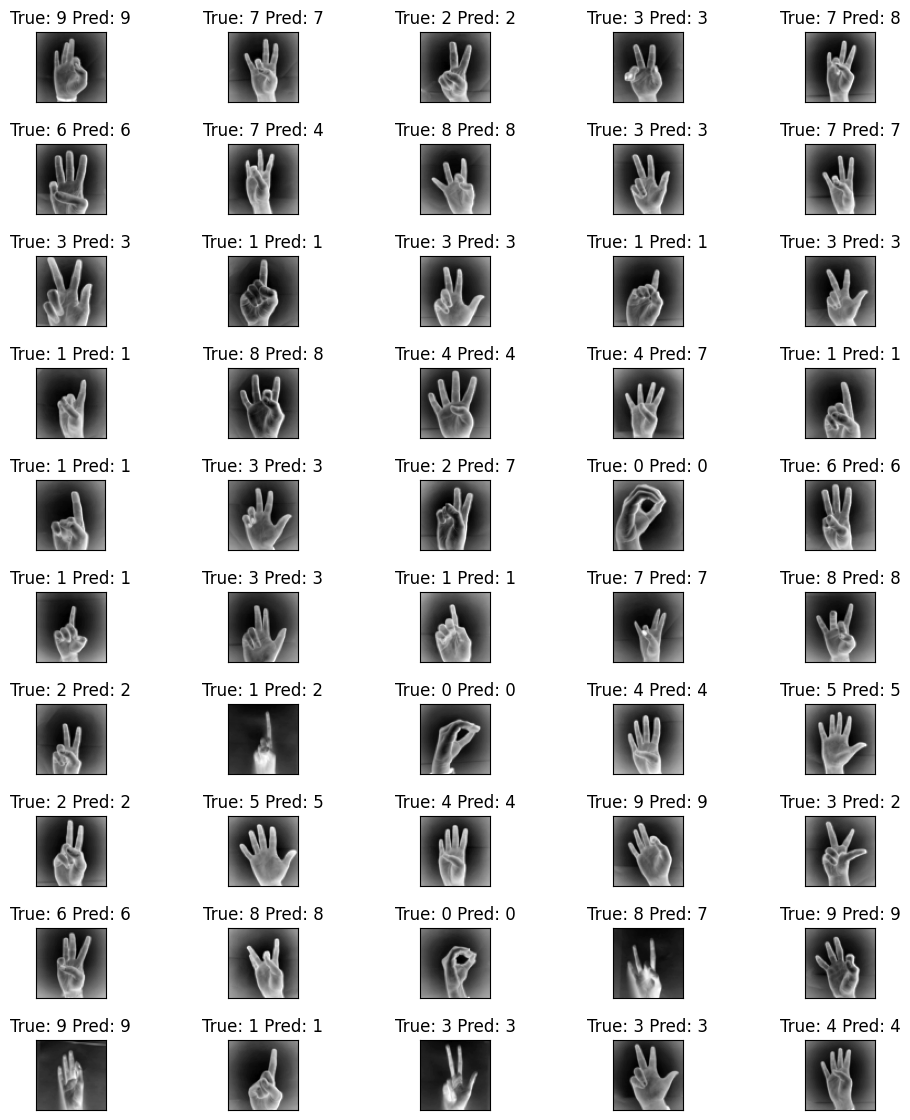

In [19]:
x_val_test =  X_test_augmented.reshape(X_test_augmented.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test_classes[i]} Pred: {tuned_y_pred_classes[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(hspace=0.6)
plt.show()